In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import xarray as xr
import numpy as np
import gsw
from sklearn.cluster import KMeans, OPTICS, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from dask.distributed import Client, progress
import matplotlib.pyplot as plt
import cartopy.crs as ccrs




In [2]:
datapath = '/lus/scratch/shao/data/NEP36_extremes/'
ds = xr.open_mfdataset(
    f'{datapath}/processed/daily/by_year/*.nc',
    parallel=True,
    engine='h5netcdf'
)

In [3]:
# Apply various mask
mask_ds = xr.open_dataset(f'{datapath}/processed/static/mask.nc')
mask = (
    (mask_ds.mask[0,:,:].squeeze()>0.) &
    (ds['S'][0,:,:]>0.) &
    (ds['depths'][0,:,:] < 1000.)
)
    
ds = ds.where(mask)

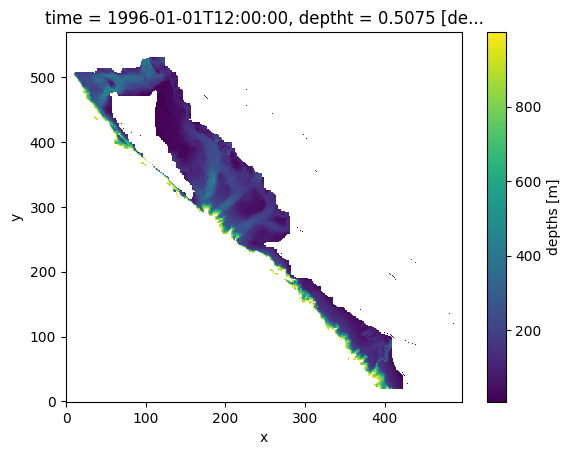

In [4]:
ds['depths'][0,:,:].plot()

In [5]:
# Create climatology
ds_clim = ds.mean('time')
ds_std = ds.std('time')


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7f68e0f5b760> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

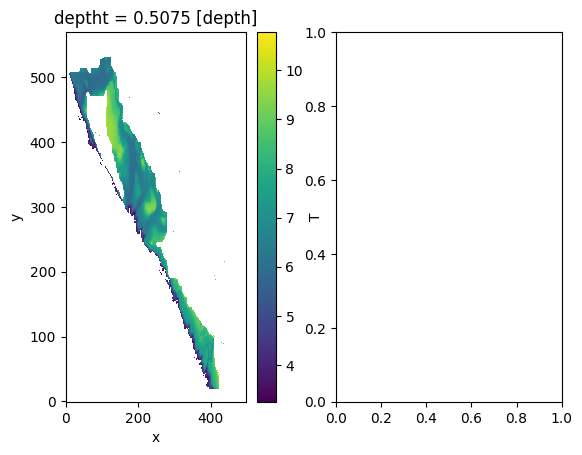

In [6]:
for var in ['T', 'AOU', 'OmegaA']:
    plt.figure()
    plt.subplot(1,2,1)
    ds_clim[var].plot()
    plt.subplot(1,2,2)
    ds[var].isel(x=175,y=400).plot()

In [7]:
# Convert to feature array
features = np.array([
    ds_clim.OmegaA.to_numpy().flatten(),
    ds_clim.AOU.to_numpy().flatten(),
    ds_clim.T.to_numpy().flatten(),
    # ds_clim.depths.to_numpy().flatten(),
    # ds_std.OmegaA.to_numpy().flatten(),
    # ds_std.AOU.to_numpy().flatten(),
    # ds_std.T.to_numpy().flatten(),
])

In [8]:
# Mask the feature array
mask_vec = mask.to_numpy().flatten() > 0.
features_masked = features[:,mask_vec]
mask_masked     = mask_vec[mask_vec]
features_masked = features_masked.transpose()

In [9]:
# Scale the features
scaler = StandardScaler()
scaler.fit(features_masked)
scaled_features = scaler.transform(features_masked)

In [ ]:
plt.scatter(scaled_features[:,1], scaled_features[:,2])

In [ ]:
print(scaler.n_features_in_, scaler.n_samples_seen_)

In [13]:
scaled_features.shape

(33751, 3)

In [11]:
for n_clusters in range(2,40):
    kmeans_region = KMeans(    
        n_clusters = n_clusters,
        n_init = 10
    )
    cluster_labels = kmeans_region.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 2 The average silhouette_score is : 0.5780830790366361
For n_clusters = 3 The average silhouette_score is : 0.5570412613531701
For n_clusters = 4 The average silhouette_score is : 0.5431260703926662
For n_clusters = 5 The average silhouette_score is : 0.5052091605295101
For n_clusters = 6 The average silhouette_score is : 0.46886772608197674
For n_clusters = 7 The average silhouette_score is : 0.432501635307195
For n_clusters = 8 The average silhouette_score is : 0.39892246694746486
For n_clusters = 9 The average silhouette_score is : 0.4039060732399283
For n_clusters = 10 The average silhouette_score is : 0.4088600243588951
For n_clusters = 11 The average silhouette_score is : 0.40348043198591704
For n_clusters = 12 The average silhouette_score is : 0.4220126142983784
For n_clusters = 13 The average silhouette_score is : 0.42675612005498875
For n_clusters = 14 The average silhouette_score is : 0.42785977008139897
For n_clusters = 15 The average silhouette_score is : 0

In [ ]:
# Perform the clustering
for n_clusters in range(2,12):
    kmeans_region = KMeans(    
        n_clusters = n_clusters,
        n_init = 10
    )
    cluster_labels = kmeans_region.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    cluster_id = np.zeros(features.shape[1])*np.nan
    cluster_id[mask_vec] = kmeans_region.labels_
    cluster_id = cluster_id.reshape(ds_clim.DIC.shape)
    ds_clim['cluster'] = (('y','x'),cluster_id)
    
    extent = [ds.nav_lon.min(), ds.nav_lon.max(), ds.nav_lat.min(), ds.nav_lat.max()]
    
    plt.figure(figsize=(24,24))
    colors = [plt.cm.tab10(i) for i in range(n_clusters)]
    for i in range(n_clusters):
        ax = plt.subplot(4,4,i+1,projection=ccrs.Miller())
        ds_clim.cluster.where(ds_clim.cluster==i).plot.contourf(
            x='nav_lon',
            y='nav_lat',
            vmin=0,
            vmax=n_clusters,
            colors=colors,
            add_colorbar=False,
            transform=ccrs.PlateCarree()
        )
        center = scaler.inverse_transform(kmeans_region.cluster_centers_[i,:].reshape(1,-1))[0]
        plt.title(f'Cluster {i}\n$\Omega_A$:{center[0]:.1f} AOU:{center[1]:.1f} T:{center[2]:.1f}')
        # plt.title(f'Cluster {i}')
        ax.coastlines()
        ax.set_extent(extent)
    plt.subplots_adjust(hspace=-0.6)
    ds_clim.to_netcdf(f'{datapath}/processed/clim/clim_with_clusters_{n_clusters}.nc')

For n_clusters = 2 The average silhouette_score is : 0.5775487105561102
For n_clusters = 3 The average silhouette_score is : 0.5570412613531701
For n_clusters = 4 The average silhouette_score is : 0.5431024980098224
For n_clusters = 5 The average silhouette_score is : 0.5044426816184353
For n_clusters = 6 The average silhouette_score is : 0.46796550905762396
For n_clusters = 7 The average silhouette_score is : 0.41232749756203724
For n_clusters = 8 The average silhouette_score is : 0.39898032644281267
For n_clusters = 9 The average silhouette_score is : 0.40411927834751715
For n_clusters = 10 The average silhouette_score is : 0.40856313612266426


In [33]:
ds_clim.to_netcdf(f'{datapath}/processed/clim/clim_with_clusters_{nclusters}.nc')

In [57]:
optics_region

OPTICS()

In [59]:
scaled_features.shape

(6, 41550)